##  <center>SENTIMENT ANALYSIS OF AMAZON PRODUCT REVIEW</center>
### <center> Condoris Dimitri & Moalla Elias</center>

### Introduction.

It is interesting to study Amazon product reviews on the internet as it might lead to interesting concrete applications. Indeed, if we can predict the sentiment of a particular user over a particular product, we can provide better services and more specific advertisings hence redirecting users to more valuable content (for them) faster. To test out our sentiment analysis method, we used the dataset from the following kaggle link: https://www.kaggle.com/sid321axn/amazon-alexa-reviews. This dataset contains thousands of Amazon customers reviews for Alexa Echo, Firestick, Echo Dot and similar products.

One could wonder why we would make such a model (saying if a review has a positive sentiment or a negative sentiment) when users can already leave star ratings for each of the product. The answer to this is that the model is mainly developed to extract features from the product that gives the positive sentiment for users allowing us to expose how good a product is to a certain demand using its description and those extracted textual features. This can therefore allow a website such as amazon to create faster and more pertinent searching bars conducting to a better user experience on the platform overall.

### Plan

The plan will here to first preprocess the data to make the usable before testing models with simple Tfid transforms. Then we will test out models based on the FastTest embedding method and classifier and lastly we will test out the FastTest embedding method with other classiers such as those used in the first part of the experiments. We will then draw results and explain what could be done afterward.

### Loading used libraries.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

### Data preparation.

In [7]:
# We launch this command to download the database directly from the git repository.

!wget https://raw.githubusercontent.com/dcondoris/nlpp/main/amazon_alexa.tsv

--2021-04-24 12:24:03--  https://raw.githubusercontent.com/dcondoris/nlpp/main/amazon_alexa.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 514752 (503K) [text/plain]
Saving to: ‘amazon_alexa.tsv.1’

amazon_alexa.tsv.1  100%[===================>] 502.69K  --.-KB/s    in 0.03s   

2021-04-24 12:24:04 (15.9 MB/s) - ‘amazon_alexa.tsv.1’ saved [514752/514752]



In [10]:
df = pd.read_csv('amazon_alexa.tsv', delimiter = '\t')

In [11]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


Our sentiment column (which will be what we try to predict) is the $\textit{feedback}$ column where 1 means that the sentiment is positive and 0 means that the sentiment is negative, the design of this column is pretty simple: if the rating is over (or equal to) 3, the sentiment is positive, else, it is negative.

In [13]:
variation = df.variation
X = df.verified_reviews
y = df.feedback
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 55)

In [14]:
print(X_train.shape)
print(X_test.shape)

(2205,)
(945,)


In [15]:
print(X_train)

2722                                         Works great!
38      This thing is way cool!  You should get one.  ...
3145    Perfect for kids, adults and everyone in betwe...
1637    The ability to respond with the accuracy and v...
86                                            Clear music
                              ...                        
2589    Not all that happy. The speaker isn’t great an...
968                                              Love it!
295     Easy to use and has great sound...It was a gre...
666                                        It was perfect
461                                              Love it!
Name: verified_reviews, Length: 2205, dtype: object


In [16]:
print(X_test)

497     I have 3-Dots and 2-Original and this new one ...
790     We like it all so far, but have a lot to try o...
376     Doesn't always respond when spoken to with pro...
549     cant seem to get this thing to sink with my wi...
206     We are still discovering all that the Echo can...
                              ...                        
33      The speakers sound pretty good for being so sm...
491                             I've already returned it.
2849    I like it alot. I connected it so I can play m...
556     Not substitute for the original.  The echo dot...
333                                               Love it
Name: verified_reviews, Length: 945, dtype: object


### Descriptive statistics.

In [17]:
df_train = df.iloc[X_train.index]
df_test = df.iloc[X_test.index]
df_train.head()

,rating,date,variation,verified_reviews,feedback
2722,5,30-Jul-18,Black Dot,Works great!,1
38,5,30-Jul-18,Charcoal Fabric,This thing is way cool! You should get one. ...,1
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
1637,3,29-Jul-18,White Show,The ability to respond with the accuracy and v...,1
86,5,30-Jul-18,Charcoal Fabric,Clear music,1


In [18]:
X_train = list(X_train)
X_test = list(X_test)
y_train = list(y_train)
y_test = list(y_test)

In [19]:
df_train.groupby('feedback').count()

,rating,date,variation,verified_reviews
feedback,,,,
0,163,163,163,163
1,2042,2042,2042,2042


We directly see that there are way more positive reviews than negative reviews, the accuracy score will therefore be biased as predicting only positive reviews will lead to a 100x2042/2205 = 92.6% accuracy (hence why using the F1-score will be extremly important here).

In [20]:
df_train_positive = df_train[df_train['feedback'] == 1]
df_train_negative = df_train[df_train['feedback'] == 0]

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
word_positive = ''.join(df_train_positive['verified_reviews'])
word_negative = ''.join(df_train_negative['verified_reviews'])

tokenized_word_positive = word_tokenize(word_positive) # We joint every reviews of each feedback
tokenized_word_negative = word_tokenize(word_negative)

In [24]:
fdist_positive = FreqDist(tokenized_word_positive) # We create the dictionary of word frequencies
fdist_negative = FreqDist(tokenized_word_negative)

print(fdist_positive.most_common(10)) # We check which words are the most common
print(fdist_negative.most_common(10))

[('.', 2268), ('the', 1775), ('to', 1737), ('I', 1675), ('and', 1413), ('it', 1381), (',', 1350), ('!', 907), ('a', 901), ('my', 827)]
[('.', 322), ('the', 273), ('to', 238), ('I', 213), (',', 197), ('it', 170), ('and', 162), ('a', 154), ('is', 115), ('of', 81)]


The most negative words are parasited by the common words of every text such as 'the', 'to', '.', etc... We therefore use a stopword set.

In [25]:
stopword = set(STOPWORDS)
stopword.update(['I', '.', '!', '?', ',', '’', 'Alexa', 'Amazon', 'Echo', 'echo'])

In [26]:
tokenized_word_positive = [w for w in tokenized_word_positive if w not in stopword]
tokenized_word_negative = [w for w in tokenized_word_negative if w not in stopword]

In [27]:
fdist_positive = FreqDist(tokenized_word_positive) # We create the dictionary of word frequencies
fdist_negative = FreqDist(tokenized_word_negative)

print(fdist_positive.most_common(10)) # We check which words are the most common
print(fdist_negative.most_common(10))

[('love', 388), ('great', 330), ('music', 308), ('use', 284), ('It', 240), ("n't", 233), ('one', 208), ("'s", 203), ('set', 191), ('The', 180)]
[("n't", 56), ('device', 43), ('t', 42), ('work', 30), ('The', 26), ('It', 25), ("'s", 22), ('use', 22), ('product', 21), ('screen', 21)]


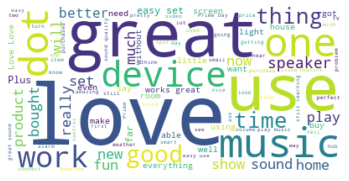

In [28]:
wordcloud_pos = WordCloud(stopwords = stopword, max_font_size = 100, max_words = 100, background_color = 'white')\
                .generate(word_positive)
plt.figure()
plt.imshow(wordcloud_pos, interpolation = 'bilinear')
plt.axis('off')
plt.show()

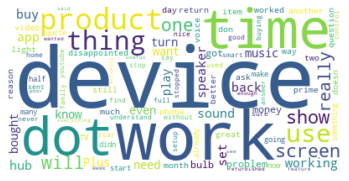

In [29]:
wordcloud_neg = WordCloud(stopwords = stopword, max_font_size = 100, max_words = 100, background_color = 'white')\
                .generate(word_negative)
plt.figure()
plt.imshow(wordcloud_neg, interpolation = 'bilinear')
plt.axis('off')
plt.show()

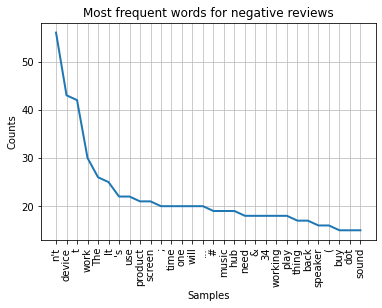

In [30]:
fdist_negative.plot(30, cumulative = False, title = "Most frequent words for negative reviews")
plt.show()

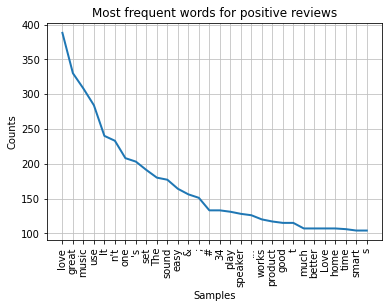

In [31]:
fdist_positive.plot(30, cumulative = False, title = "Most frequent words for positive reviews")
plt.show()

We can see that the Zipf's law is kind of verified. Using both results, we can conclude that raw classification using hand crafted feature extraction will be hard and will not lead to performing results as the most present words are common and the lesser common ones not really expressive of a sentiment (apart from 'love', 'easy', 'great' and 'good'). This might come from the fact that as users are generally well educated, they will express negative reviews without using harsh words such as 'hate', 'bad' or 'awful'.

Yet, this phenomenon might not be observable right now because of all the words that give no information such as 'it', 't' or even 'n't'. To complete the treatment of the reviews, we will therefore perform better tokenization eliminating such words using the lemmatization procedure.

### Data preprocessing.

Here, the only particular things we can observe in the dataset is the presence of emojis, this is what we mainly have to remove before doing the classical sentence preprocessing to obtain tokens.

In [32]:
X_train = [str(x.encode("ascii", "ignore"))[2:-1] for x in X_train] # Some reviews have emojis
X_test = [str(x.encode("ascii", "ignore"))[2:-1] for x in X_test]

In [33]:
n_train = len(X_train)
n_test = len(X_test)
X_train_e = [x for x in X_train if x != ' ' and x != '']
X_test_e = [x for x in X_test if x != ' ' and x != '']
y_train_e = [y_train[i] for i in range(n_train) if X_train[i] != ' ' and X_train[i] != '']
y_test_e = [y_test[i] for i in range(n_test) if X_test[i] != ' ' and X_test[i] != '']

In [34]:
index_fixed_train = []
index_fixed_test = []

for i in range(df_train.shape[0]):
    if X_train[i] != '' and X_train[i] != ' ':
        index_fixed_train.append(i)
        
for i in range(df_test.shape[0]):
    if X_test[i] != '' and X_test[i] != ' ':
        index_fixed_test.append(i)

In [36]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [37]:
corpus_train = []
list_train = X_train_e
n = len(list_train)
for i in tqdm(range(n)):
    review = re.sub("<.*?>", "", list_train[i])
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    review = [ps.stem(words) for words in review if not words in stopword]
    review = [lemmatizer.lemmatize(words) for words in review if not words in stopword]
    review = ' '.join(review)
    corpus_train.append(review)

100%|██████████| 2142/2142 [00:02<00:00, 803.27it/s]


In [38]:
corpus_test = []
list_test = X_test_e
n = len(list_test)
for i in tqdm(range(n)):
    review = re.sub("<.*?>", "", list_test[i])
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    review = [ps.stem(words) for words in review if not words in stopword]
    review = [lemmatizer.lemmatize(words) for words in review if not words in stopword]
    review = ' '.join(review)
    corpus_test.append(review)

100%|██████████| 924/924 [00:00<00:00, 2623.65it/s]


In [39]:
df_train = df_train.iloc[index_fixed_train]
df_test = df_test.iloc[index_fixed_test]

In [40]:
df_train['verified_reviews_treated'] = corpus_train
df_test['verified_reviews_treated'] = corpus_test

Now that we treated the text with different tools, we can redo the previous steps to see which words are the most common.

In [41]:
df_train_positive = df_train[df_train['feedback'] == 1]
df_train_negative = df_train[df_train['feedback'] == 0]

In [42]:
word_positive = ''.join(df_train_positive['verified_reviews_treated'])
word_negative = ''.join(df_train_negative['verified_reviews_treated'])

tokenized_word_positive = word_tokenize(word_positive) # We joint every reviews of each feedback
tokenized_word_negative = word_tokenize(word_negative)

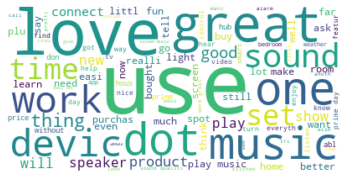

In [43]:
wordcloud_pos = WordCloud(stopwords = stopword, max_font_size = 100, max_words = 100, background_color = 'white')\
                .generate(word_positive)
plt.figure()
plt.imshow(wordcloud_pos, interpolation = 'bilinear')
plt.axis('off')
plt.show()

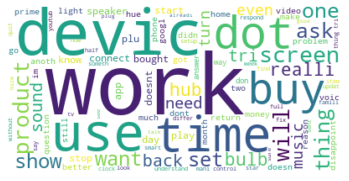

In [44]:
wordcloud_neg = WordCloud(stopwords = stopword, max_font_size = 100, max_words = 100, background_color = 'white')\
                .generate(word_negative)
plt.figure()
plt.imshow(wordcloud_neg, interpolation = 'bilinear')
plt.axis('off')
plt.show()

As we can see, it's still hard to see an evident relationship between words and sentiment (again except for specific words of the positive sentiment expression). We therefore try to develop a first model where we apply basic feature determination using special positive wordsand see how well it works out.

In [45]:
positive_words = set(['love', 'great', 'good'])
simple_train = list(df_train.verified_reviews)
determined_labels = []
for review in simple_train:
    if(positive_words.intersection(word_tokenize(review)) != set()):
        determined_labels.append(1)
    else:
        determined_labels.append(0)
determined_labels = np.array(determined_labels)

In [46]:
print(f1_score(list(1-df_train.feedback), 1-determined_labels))

0.1682600382409178


In [47]:
print(f1_score(list(1-df_train.feedback), np.ones(df_train.shape[0])))

0.1300742034046268


Considering the class with the less occurences is the 0 class, we have to redefine the feedback value so the new class of interest (which is 1 for the F1-score) is the 0 class. We then see that using this method, we obtain a better F1-score than the constant prediction case on the train dataset.

In [48]:
np.mean(df_train.feedback == determined_labels)

0.3907563025210084

In [49]:
np.mean(df_train.feedback == np.ones(df_train.shape[0]))

0.9304388422035481

Yet, the accuracy is way lower than what could be expected (which proves that a significant number of positive reviews canno't just be classified using the positive words directly).

In [50]:
simple_test = list(df_test.verified_reviews)
determined_labels_test = []
for review in simple_test:
    if(positive_words.intersection(word_tokenize(review)) != set()):
        determined_labels_test.append(1)
    else:
        determined_labels_test.append(0)
determined_labels_test = np.array(determined_labels_test)

In [51]:
print(f1_score(list(1-df_test.feedback), 1-determined_labels_test))

0.20448179271708683


In [52]:
print(f1_score(list(1-df_test.feedback), np.ones(df_test.shape[0])))

0.175715695952616


In [53]:
np.mean(df_test.feedback == determined_labels_test)

0.3852813852813853

In [54]:
np.mean(df_test.feedback == np.ones(df_test.shape[0]))

0.9036796536796536

Similar conclusions can be drawn from the test dataset which validates what we thought about this naive method.

### Machine learning methods.

We first use simple models using Tfid Vectorization of words, we will then, use the already implemented classifier of the FastText embedding algorithm.

In [55]:
y_train = list(df_train['feedback'])
y_test = list(df_test['feedback'])

In [56]:
tfid = TfidfVectorizer(max_features = 2000) 
X_train_t = tfid.fit_transform(corpus_train).toarray()
X_test_t = tfid.transform(corpus_test).toarray()

In [57]:
classifier = MultinomialNB(alpha = 1 , fit_prior=True, class_prior=None)
classifier.fit(X_train_t, y_train)
y_pred_train = classifier.predict(X_train_t)
y_pred_test = classifier.predict(X_test_t)

In [58]:
print(f1_score(list(1-y_pred_train), 1-np.array(y_train)))
np.mean(y_pred_train == y_train)

0.03846153846153846


0.9299719887955182

In [59]:
print(f1_score(list(1-y_pred_test), 1-np.array(y_test)))
np.mean(y_pred_test == y_test)

0.0


0.9036796536796536

In [60]:
classifier = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
classifier.fit(X_train_t, y_train)
y_pred_train = classifier.predict(X_train_t)
y_pred_test = classifier.predict(X_test_t)

In [61]:
print(f1_score(list(1-y_pred_train), 1-np.array(y_train)))
np.mean(y_pred_train == y_train)

0.7478991596638656


0.9719887955182073

In [62]:
print(f1_score(list(1-y_pred_test), 1-np.array(y_test)))
np.mean(y_pred_test == y_test)

0.32727272727272727


0.9199134199134199

In [63]:
classifier = LogisticRegression(solver = 'lbfgs',max_iter = 500, multi_class = "auto")
classifier.fit(X_train_t, y_train)
y_pred_train = classifier.predict(X_train_t)
y_pred_test = classifier.predict(X_test_t)

In [64]:
print(f1_score(list(1-y_pred_train), 1-np.array(y_train)))
np.mean(y_pred_train == y_train)

0.0


0.9304388422035481

In [65]:
print(f1_score(list(1-y_pred_test), 1-np.array(y_test)))
np.mean(y_pred_test == y_test)

0.0


0.9036796536796536

Obviously, the fine tuning of the parameters here will be hard as the imbalance between the two different classes is very big, nevertheless, with the SVC model we tend to obtain very good results that are better that everything we got so far !

### FastText model.

In [66]:
n_train = len(X_train_e)
n_test = len(X_test_e)
print(n_train, n_test)

2142 924


In [67]:
f = open('train.txt', 'w')
for k in range(n_train):
    f.write('__label__'+str(y_train[k])+" "+str(X_train_e[k]))
    f.write("\n")
f.close()

In [70]:
!pip install fasttext

     |████████████████████████████████| 71kB 4.9MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3092063 sha256=ac130e15eca653a1afffd50bcd1986a03f24606d8c88e1d7048fa1dacbff6bce
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [71]:
import fasttext

In [72]:
model = fasttext.train_supervised('train.txt')

y_pred = []
for k in range(n_test):
    y_pred.append(int((model.predict(str(X_test_e[k])))[0][0][9:]))
y_pred = np.array(y_pred)

In [73]:
print(f1_score(list(1-y_pred), 1-np.array(y_test)))
np.mean(y_pred == y_test)

0.02222222222222222


0.9047619047619048

Using the already implemented FastText model, we can notice worse results than those we previously implemented, neither the less we still notice a slight upgrade regarding the first results we made (and those not concering the SVC).

### FastText model using the SVC classifier and the FastText vector embedding.

In [74]:
f = open('train_emb.txt', 'w')
for k in range(n_train):
    f.write(str(X_train_e[k]))
    f.write("\n")
f.close()

In [75]:
model_emb = fasttext.train_unsupervised('train_emb.txt', model='skipgram')

In [76]:
model_emb.words

['</s>',
 'the',
 'I',
 'to',
 'and',
 'it',
 'a',
 'my',
 'is',
 'for',
 'of',
 'with',
 'have',
 'in',
 'that',
 'this',
 'but',
 'love',
 'on',
 'Echo',
 'as',
 'can',
 'so',
 'was',
 'like',
 'Alexa',
 'you',
 'not',
 'great',
 'up',
 'The',
 'Love',
 'use',
 'It',
 'music',
 'be',
 'all',
 'set',
 'it.',
 'just',
 'or',
 'more',
 'one',
 'an',
 'when',
 'are',
 'echo',
 'sound',
 'get',
 'very',
 'has',
 'easy',
 'me',
 'we',
 'play',
 'from',
 'Great',
 'do',
 'had',
 'our',
 'works',
 'We',
 'am',
 'what',
 'if',
 'would',
 'than',
 'at',
 'This',
 'will',
 'good',
 'out',
 'other',
 'speaker',
 'she',
 'much',
 'Works',
 'really',
 'Amazon',
 'bought',
 "I'm",
 'no',
 'its',
 'only',
 'about',
 'product',
 'device',
 'smart',
 'better',
 'time',
 'also',
 'even',
 'how',
 "it's",
 'still',
 'quality',
 'her',
 'having',
 'new',
 'Very',
 'because',
 'it!',
 'does',
 'some',
 'home',
 'little',
 'any',
 'they',
 'So',
 'your',
 'work',
 'things',
 'far',
 'learning',
 'My',
 'ev

In [77]:
X_train_emb = np.array([list(model_emb.get_sentence_vector(x)) for x in X_train_e]) # Matrix of the embedded vectors
X_test_emb = np.array([list(model_emb.get_sentence_vector(x)) for x in X_test_e])

In [78]:
classifier = svm.SVC(C=0.0001, kernel='sigmoid', degree=3, gamma='auto')
classifier.fit(X_train_emb, y_train)
y_pred_train = classifier.predict(X_train_emb)
y_pred_test = classifier.predict(X_test_emb)

In [79]:
print(f1_score(list(1-y_pred_test), 1-np.array(y_test)))
np.mean(y_pred_test == y_test)

0.0


0.9036796536796536

In [80]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001,'auto'],'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

In [82]:
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_emb,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   44.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [83]:
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test_emb)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [84]:
print(f1_score(list(1-grid_predictions), 1-np.array(y_test)))
np.mean(grid_predictions == y_test)

0.0


0.9036796536796536

The model here seems to be too simple and canno't find any link between the FastText embeddings and the user opinion. Despite trying to fix this, we did not find any parameters that make the SVC useful.

## Conclusion and future work.

So far, the classical model showed interesting results in which we could dig a little deeper to test out more complex algorithms such as neural networks with cross-validation. Yet, the utilization of a FastText embedding did not yield any interesting results as models seem to be too simple to handle the data structure inherited from this model hence why future work could consist of testing out harder models and if it still fails to deliver interesting results, change the way we embed the sentences by using ever word2vec or Glove or any similar algorithm.